# Project: Handwritten Digits Recognition Web App

# Table of Contents
* [Introduction](#introduction)
* [Data Preprocessing](#data_preprocessing)
    1. Missing Values Check
    2. MaxAbs Scaling
    3. Adjusting Shape And Dimensions
    4. Class Imbalance Check
    5. OneHot Encoding
    6. Data augmentation
* [Modified LeNet-5](#Modified-LeNet-5)
    * Structuring
    * Training
    * Evalution
    * Saving

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,classification_report
from sklearn.preprocessing import maxabs_scale

In [3]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets,layers, Sequential ,callbacks,metrics,losses,optimizers

## Used Libraries

In [4]:
from sklearn import __version__ as skv
from matplotlib import __version__ as pltv
from numpy import __version__ as npv
from seaborn import __version__ as snsv
from tensorflow.keras import __version__ as ksv
from flask import __version__ as fkv
from cv2 import __version__ as cvv

print(f'{"Numpy":15} {npv}')
print(f'{"Matplotlib":15} {pltv}')
print(f'{"Seaborn":15} {snsv}')
print(f'{"Scikit-Learn":15} {skv}')
print(f'{"Keras":15} {ksv}')
print(f'{"Flask":15} {fkv}')
print(f'{"OpenCV":15} {cvv}')


Numpy           1.19.5
Matplotlib      3.4.2
Seaborn         0.11.1
Scikit-Learn    0.24.2
Keras           2.5.0
Flask           2.0.1
OpenCV          4.5.3


# Data Preprocessing

In [5]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()


In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

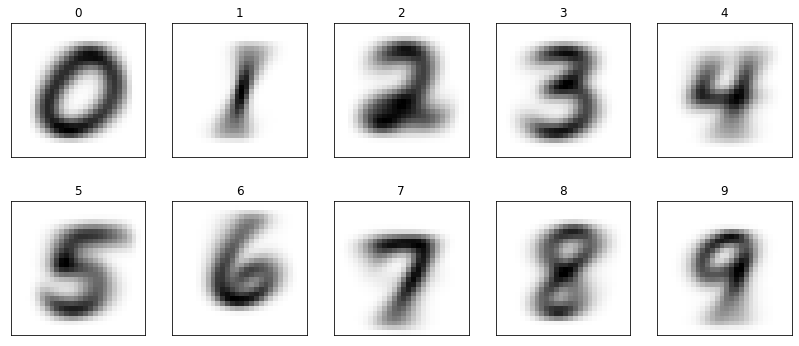

In [10]:
fig,ax = plt.subplots(2,5,figsize=(14,6))
for i in range(2):
    for j in range(5):
        ax[i,j].set_title(i*5+j)
        ax[i,j].imshow(x_train[y_train == i*5+j].mean(axis=0),cmap='gray_r')
        ax[i,j].yaxis.set_visible(False)
        ax[i,j].xaxis.set_visible(False)
plt.show()

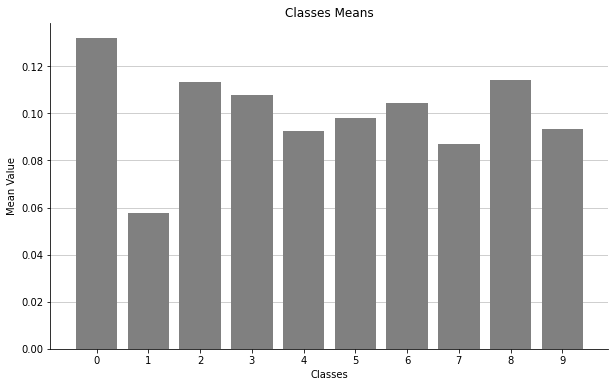

In [11]:
plt.figure(figsize=(10,6))
means = np.array([x_train[y_train == i].mean() for i in range(10)])
plt.bar(x=range(10),height=means/means.sum(),color='#808080')
plt.title('Classes Means')
plt.xlabel('Classes')
plt.ylabel('Mean Value')
plt.xticks(range(10))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)
plt.show()

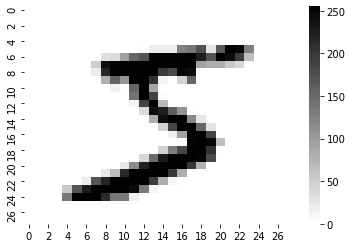

In [12]:
sns.heatmap(x_train[0],cmap='gray_r')
plt.show()

# Missing values Check

In [13]:
np.isnan(x_train).any()

False

In [14]:
np.isnan(y_train).any()

False

In [15]:
np.isnan(x_test).any()

False

In [16]:
np.isnan(y_test).any()

False

# MaxAbs Scaling

In [17]:
x_train[0].max()

255

In [18]:
x_train_scaled = np.array([maxabs_scale(x) for x in x_train])
x_test_scaled = np.array([maxabs_scale(x) for x in x_test])

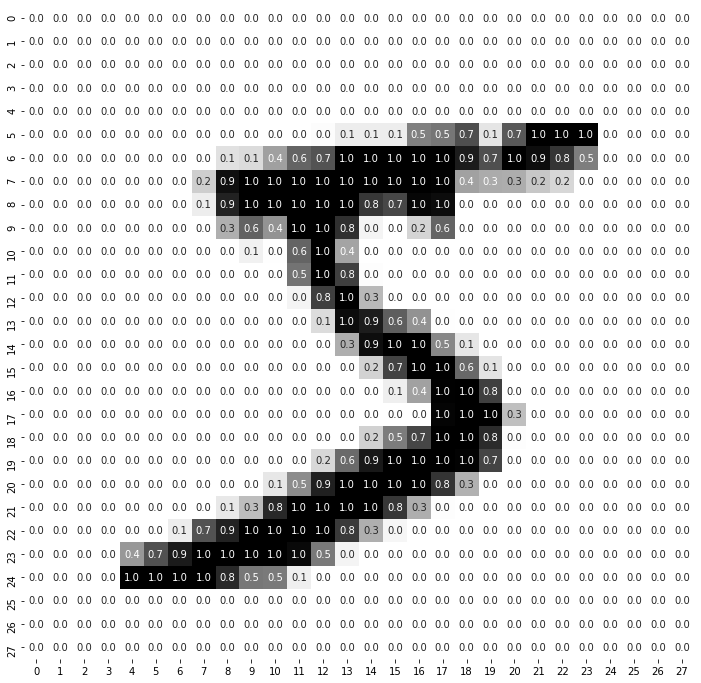

In [19]:
plt.figure(figsize=(12,12))
sns.heatmap(x_train_scaled[0],annot=True,cbar=False,cmap='gray_r',fmt='.1f')
plt.show()

# Adjusting Shape And Dimensions

In [20]:
x_train_scaled = np.expand_dims(x_train_scaled,axis=-1)
x_test_scaled = np.expand_dims(x_test_scaled,axis=-1)

In [21]:
x_train_scaled = np.pad(x_train_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test_scaled = np.pad(x_test_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [22]:
x_train_scaled.shape

(60000, 32, 32, 1)

In [23]:
x_test_scaled.shape

(10000, 32, 32, 1)

# OneHot Encoding

In [24]:
y_train_OneHot = to_categorical(y_train, num_classes = 10)
y_test_OneHot = to_categorical(y_test, num_classes = 10)

In [25]:
y_train_OneHot.shape

(60000, 10)

In [26]:
y_test_OneHot.shape

(10000, 10)

# Class Imbalance Check

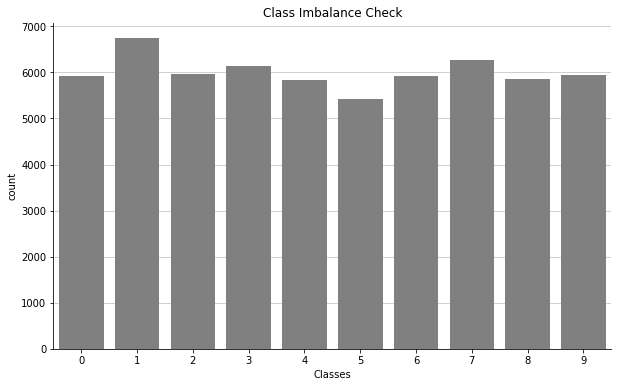

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_train,color='#808080')
plt.title('Class Imbalance Check')
plt.xlabel('Classes')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)
plt.show()

# Data augmentation

In [28]:
datagen = ImageDataGenerator(rotation_range=10,zoom_range = 0.1,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(x_train_scaled)       

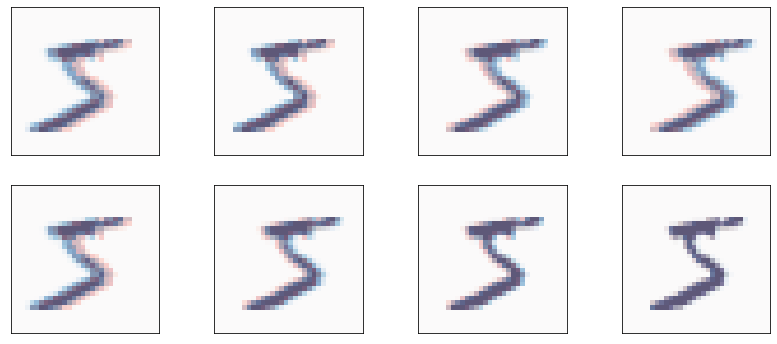

In [29]:
datagen = ImageDataGenerator(width_shift_range=0.1)
aug_iter = datagen.flow(np.expand_dims(x_train_scaled[0],axis=0), batch_size=1)
fig,ax = plt.subplots(2,4,figsize=(14,6))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(x_train_scaled[0],cmap='Reds',alpha=0.5)
        image = aug_iter.next()[0].astype(float)
        ax[i,j].imshow(image,cmap='Blues',alpha=0.5)
        ax[i,j].yaxis.set_visible(False)
        ax[i,j].xaxis.set_visible(False)
plt.show()

# LeNet-5

## Structuring

In [30]:
model_1 = Sequential()
model_1.add(layers.Conv2D(6, kernel_size=(5, 5),padding='valid', activation='tanh', input_shape=(32, 32, 1)))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2),strides = (2,2)))
model_1.add(layers.Conv2D(16, kernel_size=(5, 5),padding='valid', activation='tanh'))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2),strides = (2,2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(120, activation='tanh'))
model_1.add(layers.Dense(84, activation='tanh'))
model_1.add(layers.Dense(10, activation='softmax'))

## Training

In [31]:
optimizer = optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-7)
loss = losses.CategoricalCrossentropy()
model_1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history_1 = model_1.fit(x_train_scaled, y_train_OneHot, batch_size=100, epochs=30, verbose=1, validation_data=(x_test_scaled, y_test_OneHot))

Epoch 1/30
600/600 [==============================] - 26s 37ms/step - loss: 0.2310 - accuracy: 0.9306 - val_loss: 0.1404 - val_accuracy: 0.9573
Epoch 2/30
600/600 [==============================] - 22s 36ms/step - loss: 0.1377 - accuracy: 0.9576 - val_loss: 0.1301 - val_accuracy: 0.9617
Epoch 3/30
600/600 [==============================] - 22s 36ms/step - loss: 0.1262 - accuracy: 0.9625 - val_loss: 0.1251 - val_accuracy: 0.9650
Epoch 4/30
600/600 [==============================] - 22s 36ms/step - loss: 0.1164 - accuracy: 0.9656 - val_loss: 0.1134 - val_accuracy: 0.9666
Epoch 5/30
600/600 [==============================] - 26s 44ms/step - loss: 0.1104 - accuracy: 0.9672 - val_loss: 0.1282 - val_accuracy: 0.9601
Epoch 6/30
600/600 [==============================] - 26s 43ms/step - loss: 0.1080 - accuracy: 0.9682 - val_loss: 0.1087 - val_accuracy: 0.9707
Epoch 7/30
600/600 [==============================] - 26s 43ms/step - loss: 0.1073 - accuracy: 0.9677 - val_loss: 0.1074 - val_accuracy:

## Evaluation

In [32]:
y_pred_1 = np.argmax(model_1.predict(x_test_scaled), axis=-1)

In [33]:
print(f'{"accuracy":10} {(y_pred_1 == y_test).mean():.4f}')
print(f'{"precision":10} {precision_score(y_test,y_pred_1,average="macro"):.4f}')
print(f'{"recall":10} {recall_score(y_test,y_pred_1,average="macro"):.4f}')

accuracy   0.9705
precision  0.9705
recall     0.9703


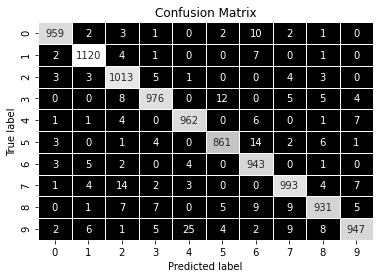

In [34]:
sns.heatmap(confusion_matrix(y_test,y_pred_1),annot=True,cbar=False,fmt="d",linewidths=.5,cmap='gray')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

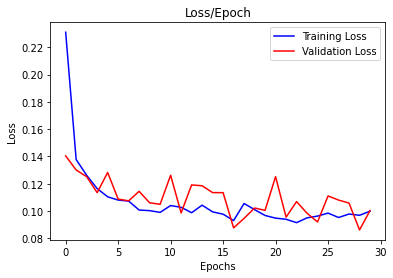

In [35]:
plt.plot(history_1.epoch,history_1.history['loss'],color='blue',label='Training Loss')
plt.plot(history_1.epoch,history_1.history['val_loss'],color='red',label='Validation Loss')
plt.title('Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

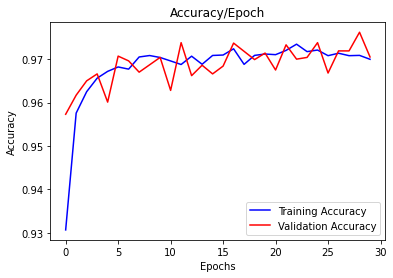

In [36]:
plt.plot(history_1.epoch,history_1.history['accuracy'],color='blue',label='Training Accuracy')
plt.plot(history_1.epoch,history_1.history['val_accuracy'],color='red',label='Validation Accuracy')
plt.title('Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Saving

In [37]:
data_dir = 'trained_models'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
model_1.save(f'{data_dir}/LeNet_5.h5')

# Modified LeNet-5

## Structuring

In [38]:
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(layers.Conv2D(filters = 6, kernel_size = (5,5),padding='valid', input_shape = (32,32,1),kernel_regularizer=l2(0.0005)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Conv2D(filters = 16, kernel_size = (5,5),padding='valid',kernel_regularizer=l2(0.0005)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(units = 250))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units = 120))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units = 84))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(units = 10, activation = 'softmax'))

## Training

In [39]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,min_lr=0.00001)
optimizer = optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-7)
loss = losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train_scaled,y_train_OneHot,batch_size=100,), 
                    epochs = 30, 
                    validation_data = (x_test_scaled,y_test_OneHot),
                    callbacks=[learning_rate_reduction],
                    verbose = 1)

Epoch 1/30
600/600 [==============================] - 63s 75ms/step - loss: 0.1997 - accuracy: 0.9445 - val_loss: 0.3504 - val_accuracy: 0.9000
Epoch 2/30
600/600 [==============================] - 42s 70ms/step - loss: 0.1204 - accuracy: 0.9722 - val_loss: 0.1217 - val_accuracy: 0.9720
Epoch 3/30
600/600 [==============================] - 42s 71ms/step - loss: 0.1045 - accuracy: 0.9772 - val_loss: 0.0939 - val_accuracy: 0.9784
Epoch 4/30
600/600 [==============================] - 46s 77ms/step - loss: 0.0991 - accuracy: 0.9783 - val_loss: 0.1121 - val_accuracy: 0.9718
Epoch 5/30
600/600 [==============================] - 46s 77ms/step - loss: 0.0969 - accuracy: 0.9794 - val_loss: 0.0815 - val_accuracy: 0.9832
Epoch 6/30
600/600 [==============================] - 47s 78ms/step - loss: 0.0942 - accuracy: 0.9804 - val_loss: 0.0872 - val_accuracy: 0.9834
Epoch 7/30
600/600 [==============================] - 47s 78ms/step - loss: 0.0922 - accuracy: 0.9804 - val_loss: 0.0820 - val_accuracy:

## Evaluation

In [40]:
y_pred = np.argmax(model.predict(x_test_scaled), axis=-1)

In [41]:
print(f'{"accuracy":10} {(y_pred == y_test).mean():.4f}')
print(f'{"precision":10} {precision_score(y_test,y_pred,average="macro"):.4f}')
print(f'{"recall":10} {recall_score(y_test,y_pred,average="macro"):.4f}')

accuracy   0.9949
precision  0.9949
recall     0.9949


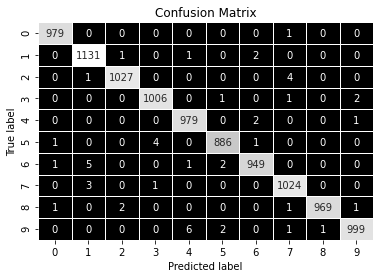

In [42]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt="d",linewidths=.5,cmap='gray')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

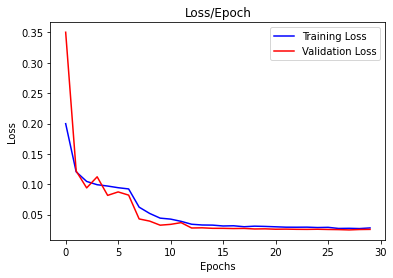

In [43]:
plt.plot(history.epoch,history.history['loss'],color='blue',label='Training Loss')
plt.plot(history.epoch,history.history['val_loss'],color='red',label='Validation Loss')
plt.title('Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

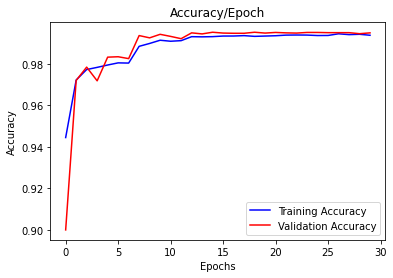

In [44]:
plt.plot(history.epoch,history.history['accuracy'],color='blue',label='Training Accuracy')
plt.plot(history.epoch,history.history['val_accuracy'],color='red',label='Validation Accuracy')
plt.title('Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Saving

In [45]:
data_dir = 'trained_models'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
model.save(f'{data_dir}/modified_LeNet_5.h5')

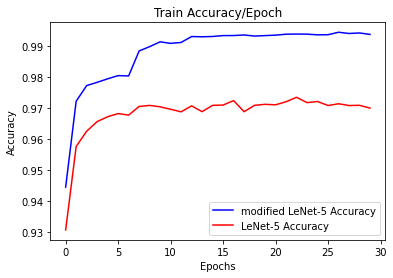

In [47]:
plt.plot(history.epoch,history.history['accuracy'],color='blue',label='modified LeNet-5 Accuracy')
plt.plot(history.epoch,history_1.history['accuracy'],color='red',label='LeNet-5 Accuracy')
plt.title('Train Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

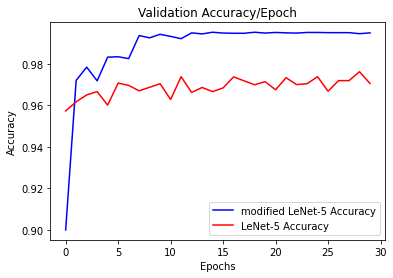

In [48]:
plt.plot(history.epoch,history.history['val_accuracy'],color='blue',label='modified LeNet-5 Accuracy')
plt.plot(history.epoch,history_1.history['val_accuracy'],color='red',label='LeNet-5 Accuracy')
plt.title('Validation Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

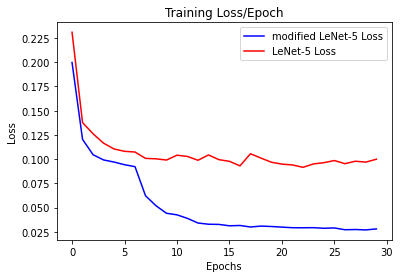

In [49]:
plt.plot(history.epoch,history.history['loss'],color='blue',label='modified LeNet-5 Loss')
plt.plot(history.epoch,history_1.history['loss'],color='red',label='LeNet-5 Loss')
plt.title('Training Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

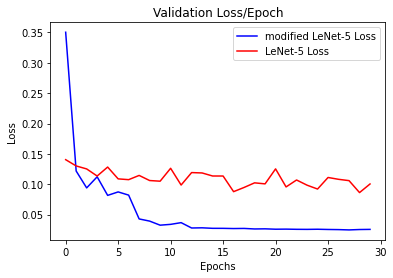

In [50]:
plt.plot(history.epoch,history.history['val_loss'],color='blue',label='modified LeNet-5 Loss')
plt.plot(history.epoch,history_1.history['val_loss'],color='red',label='LeNet-5 Loss')
plt.title('Validation Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()